## Spark SQL Queries Implementation


In [6]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("NYC Taxi Analysis") \
    .getOrCreate()

# Load the processed data - parquet format will be more efficient
taxi_data = spark.read.parquet("/root/DevDataOps/nyc-taxi-analysis/processed-data/nyc_taxi_processed.parquet")
taxi_data.show(5)
num_columns = len(taxi_data.columns)
print(f"Number of columns in the final merged and cleaned dataset : {num_columns}")

+---------+-------------------+-------------------+---------------+------------------+--------------------+--------------+-------------------+--------------------+---------------+----------------+-------------+------------------+-----------------+-----------+----------+------------------+----------+-----------------+-----------+----------+------------+-----------+--------+------------+------------+---------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|pickup_location_id|    pickup_zone_name|pickup_borough|dropoff_location_id|   dropoff_zone_name|dropoff_borough|is_inter_borough|trip_distance|trip_duration_mins|    avg_speed_mph|fare_amount|tip_amount|    tip_percentage|total_cost|    cost_per_mile|pickup_hour|pickup_day|pickup_month|pickup_year|day_type| time_of_day|payment_type|rate_code|
+---------+-------------------+-------------------+---------------+------------------+--------------------+--------------+-------------------+--------------------+-------------

## Following Prompt was used for all the queries for visualization enrichment of the data: 

"DataFrame Approach was used for visualization.

Prompt used: "Provide a visualization chart to map the most common payment references throughout the day based on the sql query implemented."

## ----------------------------------------------------------------

#### A) What is the most common payment type used per time of day (morning, afternoon, evening)?


Most Common Payment Type by Time of Day:
+------------+-----------------+-------------+-----------+----------+
|time_of_day |payment_type_desc|payment_count|total_trips|percentage|
+------------+-----------------+-------------+-----------+----------+
|morning_rush|Credit Card      |114441       |157486     |72.67     |
|midday      |Credit Card      |209212       |315384     |66.34     |
|evening_rush|Credit Card      |168990       |241091     |70.09     |
|night       |Credit Card      |224271       |315445     |71.1      |
+------------+-----------------+-------------+-----------+----------+


Most Common Payment Type by Time of Day (DataFrame API):
+------------+-----------------+-------------+-----------+----------+
|time_of_day |payment_type_desc|payment_count|total_trips|percentage|
+------------+-----------------+-------------+-----------+----------+
|morning_rush|Credit Card      |114441       |157486     |72.67     |
|midday      |Credit Card      |209212       |315384     |66

<Figure size 1200x800 with 0 Axes>

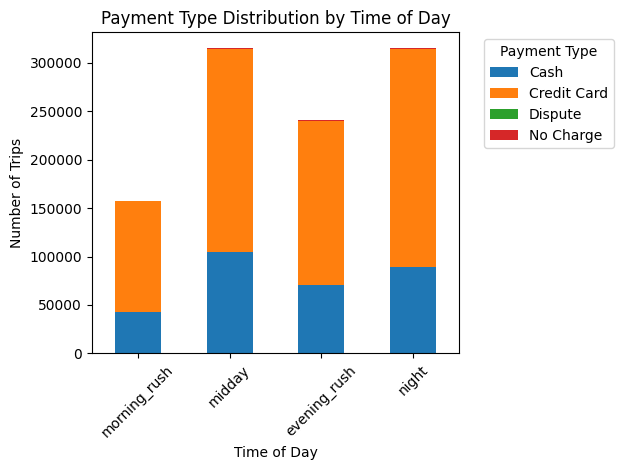

In [7]:
taxi_data.createOrReplaceTempView("trip_data")

# Map payment type codes to descriptions for better readability
from pyspark.sql.functions import when, col, desc, row_number, dense_rank
from pyspark.sql.window import Window

# Create a mapping for payment types
payment_type_mapping = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip"
}

# Add payment_type_desc column
taxi_data_with_payment_desc = taxi_data.withColumn(
    "payment_type_desc",
    when(col("payment_type") == 1, "Credit Card")
    .when(col("payment_type") == 2, "Cash")
    .when(col("payment_type") == 3, "No Charge")
    .when(col("payment_type") == 4, "Dispute")
    .when(col("payment_type") == 5, "Unknown")
    .when(col("payment_type") == 6, "Voided Trip")
    .otherwise("Other")
)

# Register the updated dataframe as a temp view
taxi_data_with_payment_desc.createOrReplaceTempView("trip_data")

# Using Spark SQL to find the most common payment type per time of day
most_common_payment_sql = """
SELECT 
    time_of_day,
    payment_type_desc,
    payment_count,
    total_trips,
    ROUND(payment_count / total_trips * 100, 2) AS percentage
FROM (
    SELECT 
        time_of_day,
        payment_type_desc,
        COUNT(*) AS payment_count,
        SUM(COUNT(*)) OVER (PARTITION BY time_of_day) AS total_trips,
        RANK() OVER (PARTITION BY time_of_day ORDER BY COUNT(*) DESC) AS payment_rank
    FROM trip_data
    GROUP BY time_of_day, payment_type_desc
) ranked
WHERE payment_rank = 1
ORDER BY 
    CASE 
        WHEN time_of_day = 'morning_rush' THEN 1
        WHEN time_of_day = 'midday' THEN 2
        WHEN time_of_day = 'evening_rush' THEN 3
        WHEN time_of_day = 'night' THEN 4
        ELSE 5
    END
"""

# Execute the query
most_common_payment_result = spark.sql(most_common_payment_sql)
print("Most Common Payment Type by Time of Day:")
most_common_payment_result.show(truncate=False)

# Alternative solution using DataFrame API
from pyspark.sql.functions import count, col, lit, first

# Group by time_of_day and payment_type_desc, count occurrences
payment_counts = taxi_data_with_payment_desc.groupBy("time_of_day", "payment_type_desc") \
    .agg(count("*").alias("payment_count"))

# Calculate total trips per time_of_day
time_of_day_totals = taxi_data_with_payment_desc.groupBy("time_of_day") \
    .agg(count("*").alias("total_trips"))

# Join the counts with the totals
payment_with_totals = payment_counts.join(time_of_day_totals, "time_of_day")

# Calculate percentage
payment_with_totals = payment_with_totals.withColumn(
    "percentage", 
    (col("payment_count") / col("total_trips") * 100).cast("double")
)

# Define window to find the most common payment type for each time of day
window_spec = Window.partitionBy("time_of_day").orderBy(col("payment_count").desc())

# Rank payment types within each time of day
ranked_payments = payment_with_totals.withColumn("rank", dense_rank().over(window_spec))

# Filter to only the top payment type for each time of day
most_common_payment_df = ranked_payments.filter(col("rank") == 1)

# Order by time of day in a logical sequence
time_of_day_order = {
    "morning_rush": 1, 
    "midday": 2, 
    "evening_rush": 3, 
    "night": 4
}

# Create a new column for sorting and then drop it
most_common_payment_df = most_common_payment_df.withColumn(
    "time_order",
    when(col("time_of_day") == "morning_rush", lit(1))
    .when(col("time_of_day") == "midday", lit(2))
    .when(col("time_of_day") == "evening_rush", lit(3))
    .when(col("time_of_day") == "night", lit(4))
    .otherwise(lit(5))
)

most_common_payment_df = most_common_payment_df.orderBy("time_order")

# Show the results from DataFrame API approach
print("\nMost Common Payment Type by Time of Day (DataFrame API):")
most_common_payment_df.select(
    "time_of_day", 
    "payment_type_desc", 
    "payment_count", 
    "total_trips", 
    col("percentage").cast("decimal(5,2)").alias("percentage")
).show(truncate=False)

# Create visualization of payment types by time of day
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert Spark DataFrame to Pandas
payment_distribution_pd = taxi_data_with_payment_desc.groupBy("time_of_day", "payment_type_desc") \
    .agg(count("*").alias("count")) \
    .toPandas()

# Pivot the data for plotting
payment_pivot = payment_distribution_pd.pivot(index='time_of_day', columns='payment_type_desc', values='count')
payment_pivot = payment_pivot.fillna(0)

# Set custom order for time_of_day
time_order = ['morning_rush', 'midday', 'evening_rush', 'night']
payment_pivot = payment_pivot.reindex(time_order)

# Plot the data
plt.figure(figsize=(12, 8))
payment_pivot.plot(kind='bar', stacked=True)
plt.title('Payment Type Distribution by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.legend(title='Payment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### B)  Which boroughs generate the highest total revenue based on pickup locations, and how do they compare in terms of trip volume?

Boroughs by Total Revenue:
+--------------+--------------------+----------+--------------------+-------------------------+
|pickup_borough|total_revenue       |trip_count|avg_revenue_per_trip|percentage_of_total_trips|
+--------------+--------------------+----------+--------------------+-------------------------+
|Manhattan     |1.3316035560013786E7|936003    |14.226488120245113  |90.93                    |
|Queens        |2900501.3299998464  |64297     |45.11099009284798   |6.25                     |
|Brooklyn      |235905.11999999647  |12819     |18.402770886964387  |1.25                     |
|Bronx         |29315.610000000044  |1132      |25.897181978798624  |0.11                     |
|EWR           |1290.27             |17        |75.89823529411764   |0.00                     |
|Staten Island |807.0399999999998   |17        |47.47294117647058   |0.00                     |
+--------------+--------------------+----------+--------------------+-------------------------+

+-----------

/tmp/ipykernel_333056/667483285.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(borough_stats_pd['pickup_borough'], rotation=45, ha='right')


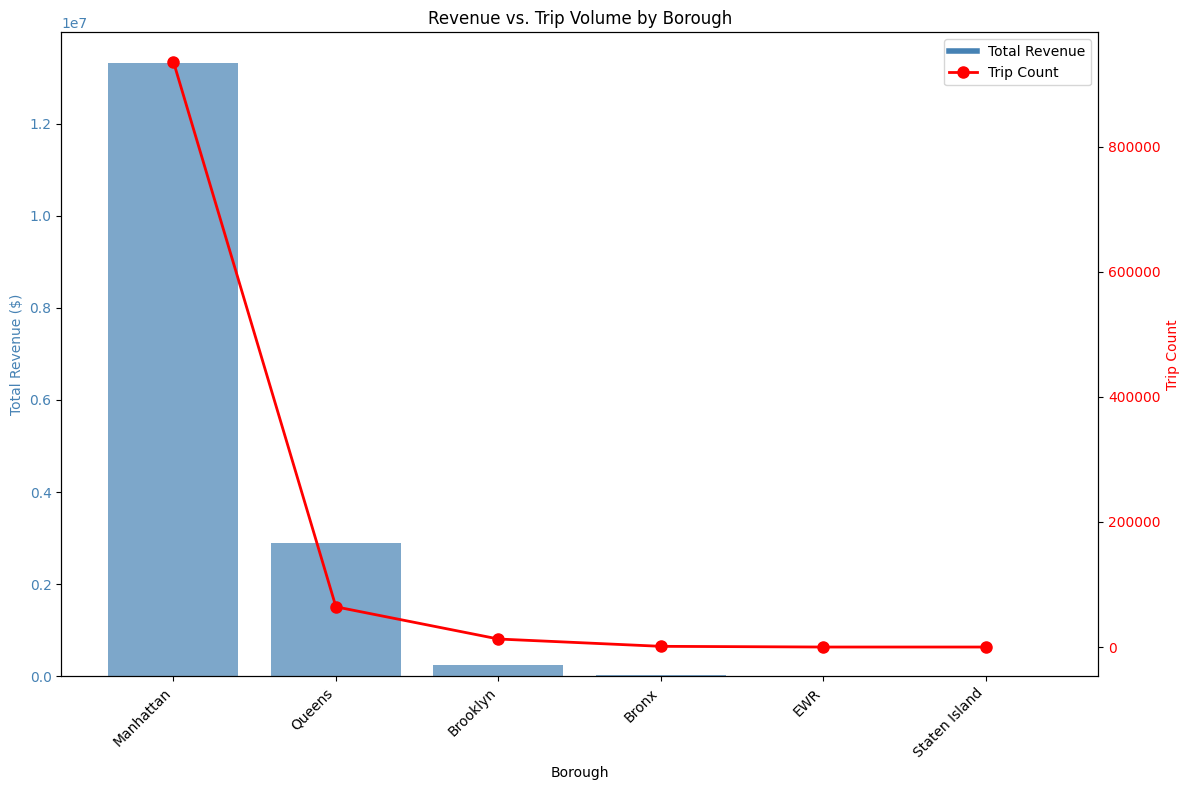

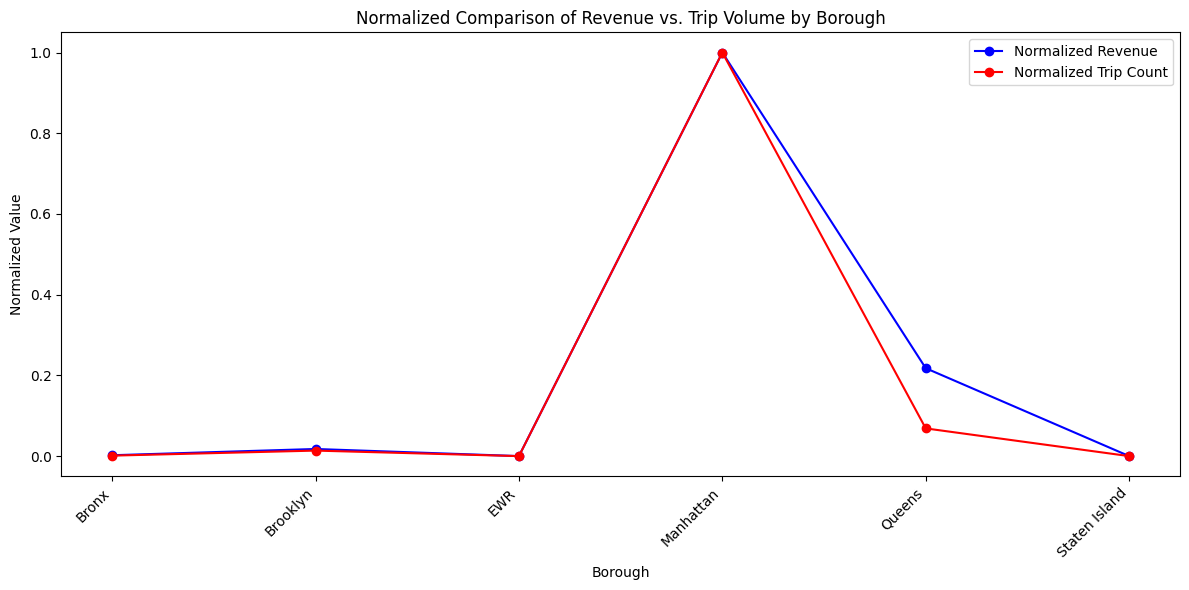

In [8]:
# Using Spark SQL to find boroughs with the highest total revenue
revenue_by_borough_sql = """
SELECT 
    pickup_borough,
    SUM(total_cost) AS total_revenue,
    COUNT(*) AS trip_count,
    SUM(total_cost) / COUNT(*) AS avg_revenue_per_trip,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM trip_data), 2) AS percentage_of_total_trips
FROM trip_data
WHERE pickup_borough IS NOT NULL
GROUP BY pickup_borough
ORDER BY total_revenue DESC
"""

# Execute the query
revenue_by_borough_result = spark.sql(revenue_by_borough_sql)
print("Boroughs by Total Revenue:")
revenue_by_borough_result.show(truncate=False)

# Alternative solution using DataFrame API
from pyspark.sql.functions import sum as spark_sum, round as spark_round

# Get total revenue, trip count, and average revenue per trip for each borough
borough_stats = taxi_data_with_payment_desc.filter(col("pickup_borough").isNotNull()) \
    .groupBy("pickup_borough") \
    .agg(
        spark_sum("total_cost").alias("total_revenue"),
        count("*").alias("trip_count"),
        (spark_sum("total_cost") / count("*")).alias("avg_revenue_per_trip")
    )

# Calculate total trip count for percentage calculation
total_trips = taxi_data_with_payment_desc.count()
borough_stats = borough_stats.withColumn(
    "percentage_of_total_trips", 
    spark_round(col("trip_count") * 100.0 / total_trips, 2)
)

# Order by total revenue
borough_stats = borough_stats.orderBy(col("total_revenue").desc())

# Show the results from DataFrame API approach
print("\nBoroughs by Total Revenue (DataFrame API):")
borough_stats.show(truncate=False)

# Create visualization comparing revenue and trip volume by borough
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Convert Spark DataFrame to Pandas for visualization
borough_stats_pd = borough_stats.toPandas()

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar chart for total revenue
bars = ax1.bar(borough_stats_pd['pickup_borough'], borough_stats_pd['total_revenue'], color='steelblue', alpha=0.7)
ax1.set_xlabel('Borough')
ax1.set_ylabel('Total Revenue ($)', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xticklabels(borough_stats_pd['pickup_borough'], rotation=45, ha='right')

# Create a secondary y-axis for trip count
ax2 = ax1.twinx()
line = ax2.plot(borough_stats_pd['pickup_borough'], borough_stats_pd['trip_count'], 'ro-', linewidth=2, markersize=8)
ax2.set_ylabel('Trip Count', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and legend
plt.title('Revenue vs. Trip Volume by Borough')
plt.tight_layout()

# Add a legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='steelblue', lw=4),
                Line2D([0], [0], color='red', lw=2, marker='o', markersize=8)]
ax1.legend(custom_lines, ['Total Revenue', 'Trip Count'], loc='upper right')

plt.show()

# Create a normalized comparison to better see the relationship pattern
borough_stats_pd['normalized_revenue'] = borough_stats_pd['total_revenue'] / borough_stats_pd['total_revenue'].max()
borough_stats_pd['normalized_trips'] = borough_stats_pd['trip_count'] / borough_stats_pd['trip_count'].max()

plt.figure(figsize=(12, 6))
borough_stats_pd = borough_stats_pd.sort_values('pickup_borough')  # Sort alphabetically for this chart
plt.plot(borough_stats_pd['pickup_borough'], borough_stats_pd['normalized_revenue'], 'bo-', label='Normalized Revenue')
plt.plot(borough_stats_pd['pickup_borough'], borough_stats_pd['normalized_trips'], 'ro-', label='Normalized Trip Count')
plt.xlabel('Borough')
plt.ylabel('Normalized Value')
plt.title('Normalized Comparison of Revenue vs. Trip Volume by Borough')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### C) What is the average tip amount per passenger count?

Average Tip Amount by Passenger Count:
+---------------+--------------+------------------+----------+
|passenger_count|avg_tip_amount|avg_tip_percentage|trip_count|
+---------------+--------------+------------------+----------+
|1.0            |1.87          |19.28             |738336    |
|2.0            |1.86          |14.38             |152189    |
|3.0            |1.83          |14.22             |43428     |
|4.0            |1.7           |14.12             |20463     |
|5.0            |1.88          |14.75             |46912     |
|6.0            |1.87          |14.78             |28078     |
+---------------+--------------+------------------+----------+


Average Tip Amount by Passenger Count (DataFrame API):
+---------------+--------------+------------------+----------+
|passenger_count|avg_tip_amount|avg_tip_percentage|trip_count|
+---------------+--------------+------------------+----------+
|1.0            |1.87          |19.28             |738336    |
|2.0            |1.86 

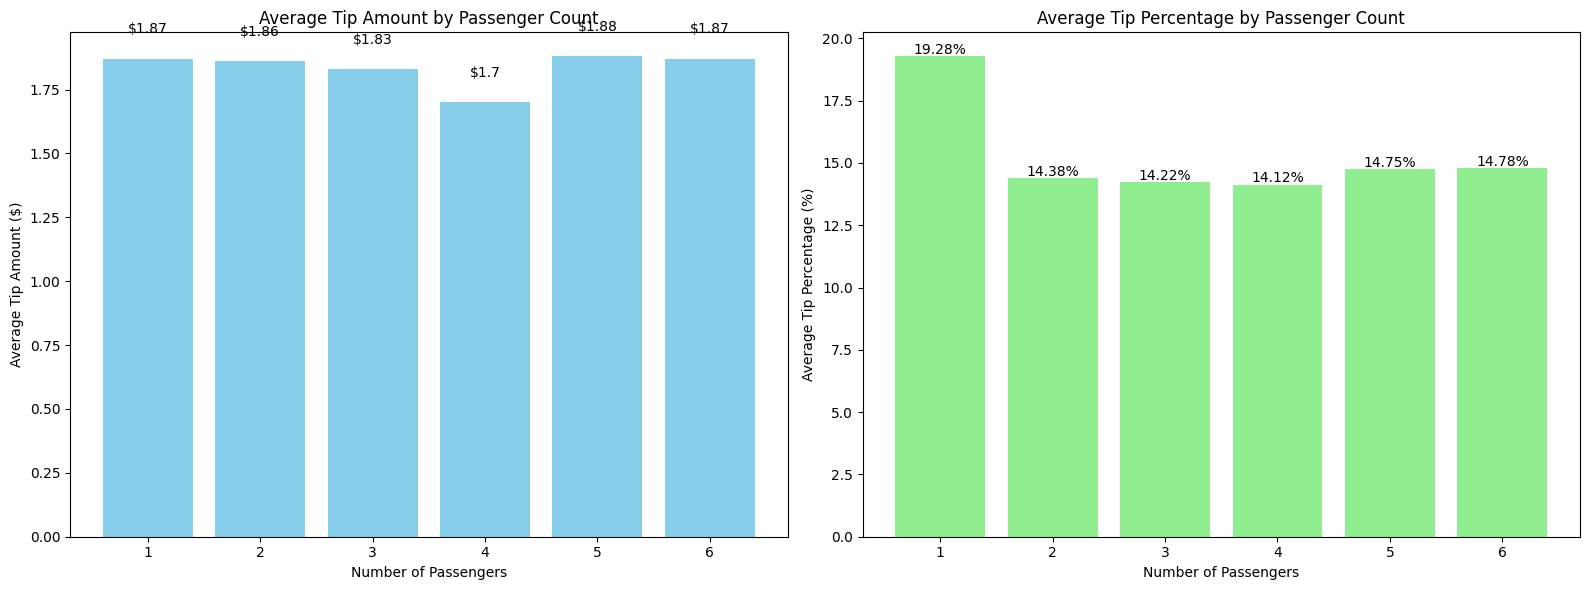

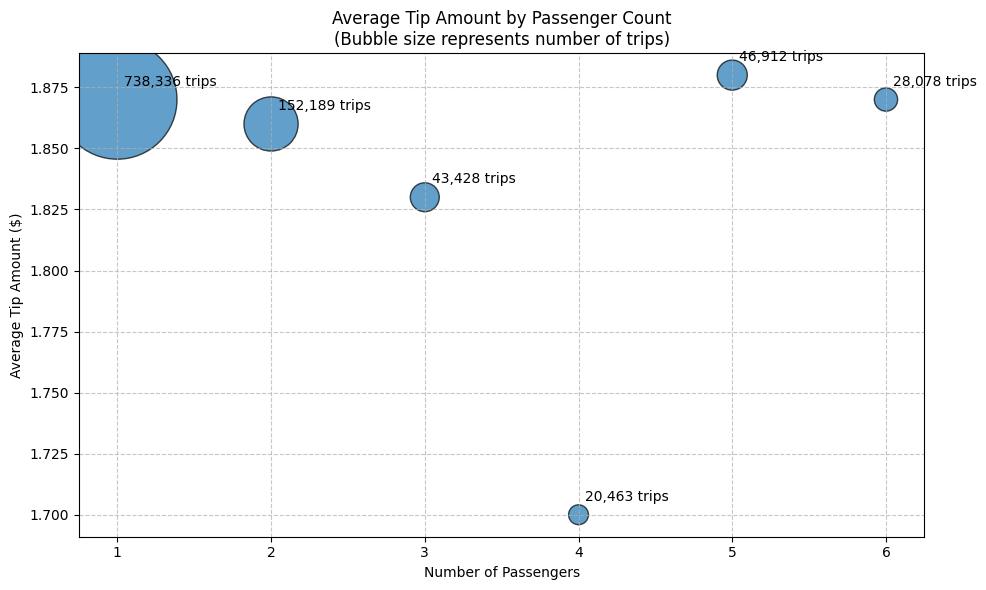

In [9]:
# Using Spark SQL to find average tip amount per passenger count
tip_by_passenger_sql = """
SELECT 
    passenger_count,
    ROUND(AVG(tip_amount), 2) AS avg_tip_amount,
    ROUND(AVG(tip_percentage), 2) AS avg_tip_percentage,
    COUNT(*) AS trip_count
FROM trip_data
WHERE passenger_count BETWEEN 1 AND 6  -- Filter to reasonable passenger counts
GROUP BY passenger_count
ORDER BY passenger_count
"""

# Execute the query
tip_by_passenger_result = spark.sql(tip_by_passenger_sql)
print("Average Tip Amount by Passenger Count:")
tip_by_passenger_result.show(truncate=False)

# Alternative solution using DataFrame API
from pyspark.sql.functions import avg, round as spark_round

# Filter to reasonable passenger counts
passenger_filtered = taxi_data_with_payment_desc.filter(col("passenger_count").between(1, 6))

# Calculate average tip amount and percentage per passenger count
tip_stats = passenger_filtered.groupBy("passenger_count") \
    .agg(
        spark_round(avg("tip_amount"), 2).alias("avg_tip_amount"),
        spark_round(avg("tip_percentage"), 2).alias("avg_tip_percentage"),
        count("*").alias("trip_count")
    ) \
    .orderBy("passenger_count")

# Show the results from DataFrame API approach
print("\nAverage Tip Amount by Passenger Count (DataFrame API):")
tip_stats.show(truncate=False)

# Create visual comparison of average tip amount vs. passenger count
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert Spark DataFrame to Pandas for visualization
tip_stats_pd = tip_stats.toPandas()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot average tip amount by passenger count
ax1.bar(tip_stats_pd['passenger_count'], tip_stats_pd['avg_tip_amount'], color='skyblue')
ax1.set_xlabel('Number of Passengers')
ax1.set_ylabel('Average Tip Amount ($)')
ax1.set_title('Average Tip Amount by Passenger Count')
ax1.set_xticks(tip_stats_pd['passenger_count'])
for i, v in enumerate(tip_stats_pd['avg_tip_amount']):
    ax1.text(i+1, v + 0.1, f"${v}", ha='center')

# Plot average tip percentage by passenger count
ax2.bar(tip_stats_pd['passenger_count'], tip_stats_pd['avg_tip_percentage'], color='lightgreen')
ax2.set_xlabel('Number of Passengers')
ax2.set_ylabel('Average Tip Percentage (%)')
ax2.set_title('Average Tip Percentage by Passenger Count')
ax2.set_xticks(tip_stats_pd['passenger_count'])
for i, v in enumerate(tip_stats_pd['avg_tip_percentage']):
    ax2.text(i+1, v + 0.1, f"{v}%", ha='center')

plt.tight_layout()
plt.show()

# Create a bubble chart showing the relationship between passenger count, tip amount, and trip count
plt.figure(figsize=(10, 6))
plt.scatter(
    tip_stats_pd['passenger_count'], 
    tip_stats_pd['avg_tip_amount'], 
    s=tip_stats_pd['trip_count']/100, # Scale down the trip count for reasonable bubble sizes
    alpha=0.7,
    edgecolors='k'
)
plt.xlabel('Number of Passengers')
plt.ylabel('Average Tip Amount ($)')
plt.title('Average Tip Amount by Passenger Count\n(Bubble size represents number of trips)')
plt.xticks(tip_stats_pd['passenger_count'])
plt.grid(True, linestyle='--', alpha=0.7)

# Add annotations with trip counts
for i, row in tip_stats_pd.iterrows():
    plt.annotate(
        f"{int(row['trip_count']):,} trips",
        (row['passenger_count'], row['avg_tip_amount']),
        xytext=(5, 10),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

#### D) What are the best 5 locations for drivers to pick up passengers from and at which time of the day?

Best 5 Pickup Locations and Times:


25/05/21 16:49:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 16:49:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 16:49:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 16:49:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 16:49:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 16:49:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 1

+------------------+-----------------+--------------+------------+----------+--------+-------+------------------+-------------+
|pickup_location_id|pickup_zone_name |pickup_borough|time_of_day |trip_count|avg_fare|avg_tip|avg_total_earnings|combined_rank|
+------------------+-----------------+--------------+------------+----------+--------+-------+------------------+-------------+
|132               |JFK Airport      |Queens        |night       |9234      |55.06   |6.18   |61.24             |1            |
|132               |JFK Airport      |Queens        |evening_rush|6300      |60.4    |6.37   |66.77             |2            |
|132               |JFK Airport      |Queens        |midday      |6589      |57.74   |5.74   |63.48             |3            |
|138               |LaGuardia Airport|Queens        |midday      |10119     |43.88   |5.65   |49.52             |4            |
|138               |LaGuardia Airport|Queens        |evening_rush|7526      |43.25   |5.87   |49.12     

25/05/21 16:49:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 16:49:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 16:49:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 16:49:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 16:49:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 16:49:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 1

+------------------+-----------------+--------------+------------+----------+--------+-------+------------------+------------------+-------------+
|pickup_location_id|pickup_zone_name |pickup_borough|time_of_day |trip_count|avg_fare|avg_tip|avg_total_earnings|combined_score    |combined_rank|
+------------------+-----------------+--------------+------------+----------+--------+-------+------------------+------------------+-------------+
|132               |JFK Airport      |Queens        |night       |9234      |55.06   |6.18   |61.24             |5884.778449389578 |1            |
|132               |JFK Airport      |Queens        |evening_rush|6300      |60.4    |6.37   |66.77             |5299.704451193481 |2            |
|132               |JFK Airport      |Queens        |midday      |6589      |57.74   |5.74   |63.48             |5152.840170779606 |3            |
|138               |LaGuardia Airport|Queens        |midday      |10119     |43.88   |5.65   |49.52             |4981.

25/05/21 16:49:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 16:49:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 16:49:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 16:49:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 16:49:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 16:49:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/21 1

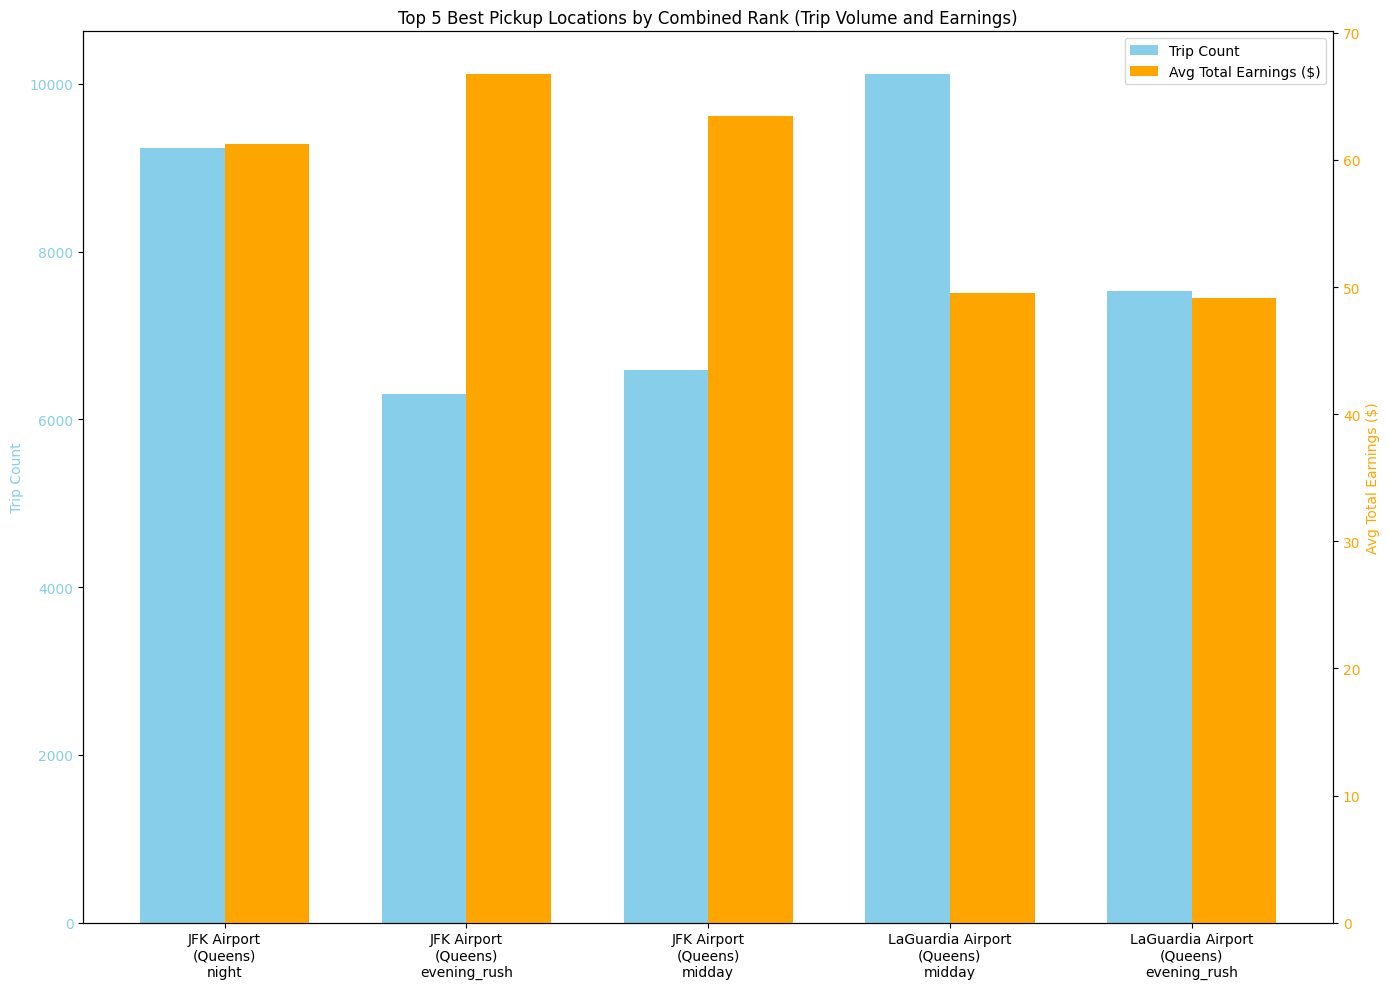

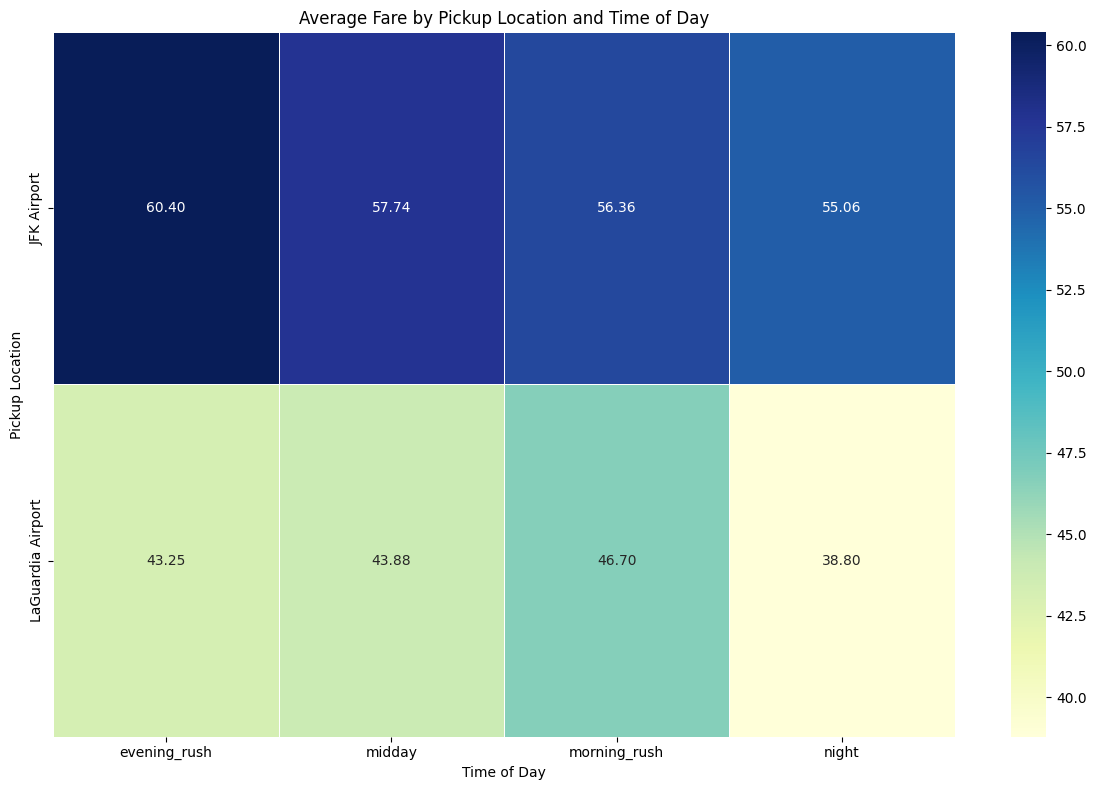

In [11]:
# Using Spark SQL to find the best pickup locations and times
best_pickup_locations_sql = """
WITH pickup_stats AS (
    SELECT 
        pickup_location_id,
        pickup_zone_name,
        pickup_borough,
        time_of_day,
        COUNT(*) AS trip_count,
        ROUND(AVG(total_cost), 2) AS avg_fare,
        ROUND(AVG(tip_amount), 2) AS avg_tip,
        ROUND(AVG(tip_amount) + AVG(total_cost), 2) AS avg_total_earnings
    FROM trip_data
    WHERE pickup_zone_name IS NOT NULL
    GROUP BY 
        pickup_location_id,
        pickup_zone_name,
        pickup_borough,
        time_of_day
),
location_rankings AS (
    SELECT 
        pickup_location_id,
        pickup_zone_name,
        pickup_borough,
        time_of_day,
        trip_count,
        avg_fare,
        avg_tip,
        avg_total_earnings,
        DENSE_RANK() OVER (ORDER BY avg_total_earnings DESC) AS earnings_rank,
        DENSE_RANK() OVER (ORDER BY trip_count DESC) AS volume_rank,
        DENSE_RANK() OVER (ORDER BY (avg_total_earnings * SQRT(trip_count)) DESC) AS combined_rank
    FROM pickup_stats
)
SELECT 
    pickup_location_id,
    pickup_zone_name,
    pickup_borough,
    time_of_day,
    trip_count,
    avg_fare,
    avg_tip,
    avg_total_earnings,
    combined_rank
FROM location_rankings
WHERE combined_rank <= 5
ORDER BY combined_rank
"""

# Execute the query
best_pickup_result = spark.sql(best_pickup_locations_sql)
print("Best 5 Pickup Locations and Times:")
best_pickup_result.show(truncate=False)

# Alternative solution using DataFrame API
from pyspark.sql.functions import sqrt, expr

# Group by pickup location and time of day
pickup_stats = taxi_data_with_payment_desc.filter(col("pickup_zone_name").isNotNull()) \
    .groupBy("pickup_location_id", "pickup_zone_name", "pickup_borough", "time_of_day") \
    .agg(
        count("*").alias("trip_count"),
        spark_round(avg("total_cost"), 2).alias("avg_fare"),
        spark_round(avg("tip_amount"), 2).alias("avg_tip"),
        spark_round(avg("tip_amount") + avg("total_cost"), 2).alias("avg_total_earnings")
    )

# Add a column for combined score (earnings * sqrt(trip_count))
pickup_stats = pickup_stats.withColumn(
    "combined_score",
    col("avg_total_earnings") * sqrt(col("trip_count"))
)

# Define window for ranking
window_combined = Window.orderBy(col("combined_score").desc())

# Add rankings
ranked_locations = pickup_stats \
    .withColumn("combined_rank", dense_rank().over(window_combined))

# Get top 5 locations
best_locations_df = ranked_locations \
    .filter(col("combined_rank") <= 5) \
    .orderBy("combined_rank")

# Show the results from DataFrame API approach
print("\nBest 5 Pickup Locations and Times (DataFrame API):")
best_locations_df.show(truncate=False)

# Create visualization of best pickup locations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert to pandas for visualization
best_locations_pd = best_locations_df.toPandas()

# Create a figure
plt.figure(figsize=(14, 10))

# Create a grouped bar chart
bar_width = 0.35
x = np.arange(len(best_locations_pd))

# Plot bars for trip count (on left y-axis)
ax1 = plt.subplot(111)
bars1 = ax1.bar(x - bar_width/2, best_locations_pd['trip_count'], bar_width, color='skyblue', label='Trip Count')
ax1.set_ylabel('Trip Count', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Create second y-axis for earnings
ax2 = ax1.twinx()
bars2 = ax2.bar(x + bar_width/2, best_locations_pd['avg_total_earnings'], bar_width, color='orange', label='Avg Total Earnings ($)')
ax2.set_ylabel('Avg Total Earnings ($)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Set x-axis labels and title
plt.title('Top 5 Best Pickup Locations by Combined Rank (Trip Volume and Earnings)')
location_labels = [f"{row['pickup_zone_name']}\n({row['pickup_borough']})\n{row['time_of_day']}" 
                  for _, row in best_locations_pd.iterrows()]
plt.xticks(x, location_labels, rotation=45, ha='right')

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()    # Create a heatmap showing best time of day for top pickup locations
    # First, get data for the top 5 pickup locations across all times of day
top_location_ids = best_locations_pd['pickup_location_id'].unique().tolist()

all_times_for_top_locations = taxi_data_with_payment_desc \
        .filter(col("pickup_location_id").isin(top_location_ids)) \
        .groupBy("pickup_location_id", "pickup_zone_name", "time_of_day") \
        .agg(
            avg("total_cost").alias("avg_fare"), 
            count("*").alias("trip_count")
        ) \
        .toPandas()

# Pivot the data for the heatmap
heatmap_data = all_times_for_top_locations.pivot_table(
    values="avg_fare", 
    index="pickup_zone_name",
    columns="time_of_day"
)

# Sort the heatmap rows by the best locations
heatmap_data = heatmap_data.reindex(best_locations_pd['pickup_zone_name'].unique())

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Average Fare by Pickup Location and Time of Day")
plt.ylabel("Pickup Location")
plt.xlabel("Time of Day")
plt.tight_layout()
plt.show()

#### E) What are the top 5 longest trips recorded in the dataset and display their corresponding trip duration, fare, pickup and dropoff zones, and payment type. Comment on whether these trips also resulted in high fares or if any anomalies are observed.

Top 5 Longest Trips:


+-------------+------------------+-----------+----------+---------------------------+--------------+-----------------+---------------+----------------+-----------------+------------------+
|trip_distance|trip_duration_mins|fare_amount|total_cost|pickup_zone_name           |pickup_borough|dropoff_zone_name|dropoff_borough|is_inter_borough|payment_type_desc|avg_speed_mph     |
+-------------+------------------+-----------+----------+---------------------------+--------------+-----------------+---------------+----------------+-----------------+------------------+
|152.9        |217.0             |225.0      |225.3     |TriBeCa/Civic Center       |Manhattan     |JFK Airport      |Queens         |true            |No Charge        |42.276497695852534|
|84.38        |69.0              |326.0      |378.32    |JFK Airport                |Queens        |NULL             |NULL           |false           |Credit Card      |73.37391304347827 |
|76.75        |106.0             |339.5      |352.8    

+-------------+------------------+-----------+----------+---------------------------+--------------+-----------------+---------------+----------------+-----------------+------------------+
|trip_distance|trip_duration_mins|fare_amount|total_cost|pickup_zone_name           |pickup_borough|dropoff_zone_name|dropoff_borough|is_inter_borough|payment_type_desc|avg_speed_mph     |
+-------------+------------------+-----------+----------+---------------------------+--------------+-----------------+---------------+----------------+-----------------+------------------+
|152.9        |217.0             |225.0      |225.3     |TriBeCa/Civic Center       |Manhattan     |JFK Airport      |Queens         |true            |No Charge        |42.276497695852534|
|84.38        |69.0              |326.0      |378.32    |JFK Airport                |Queens        |NULL             |NULL           |false           |Credit Card      |73.37391304347827 |
|76.75        |106.0             |339.5      |352.8    

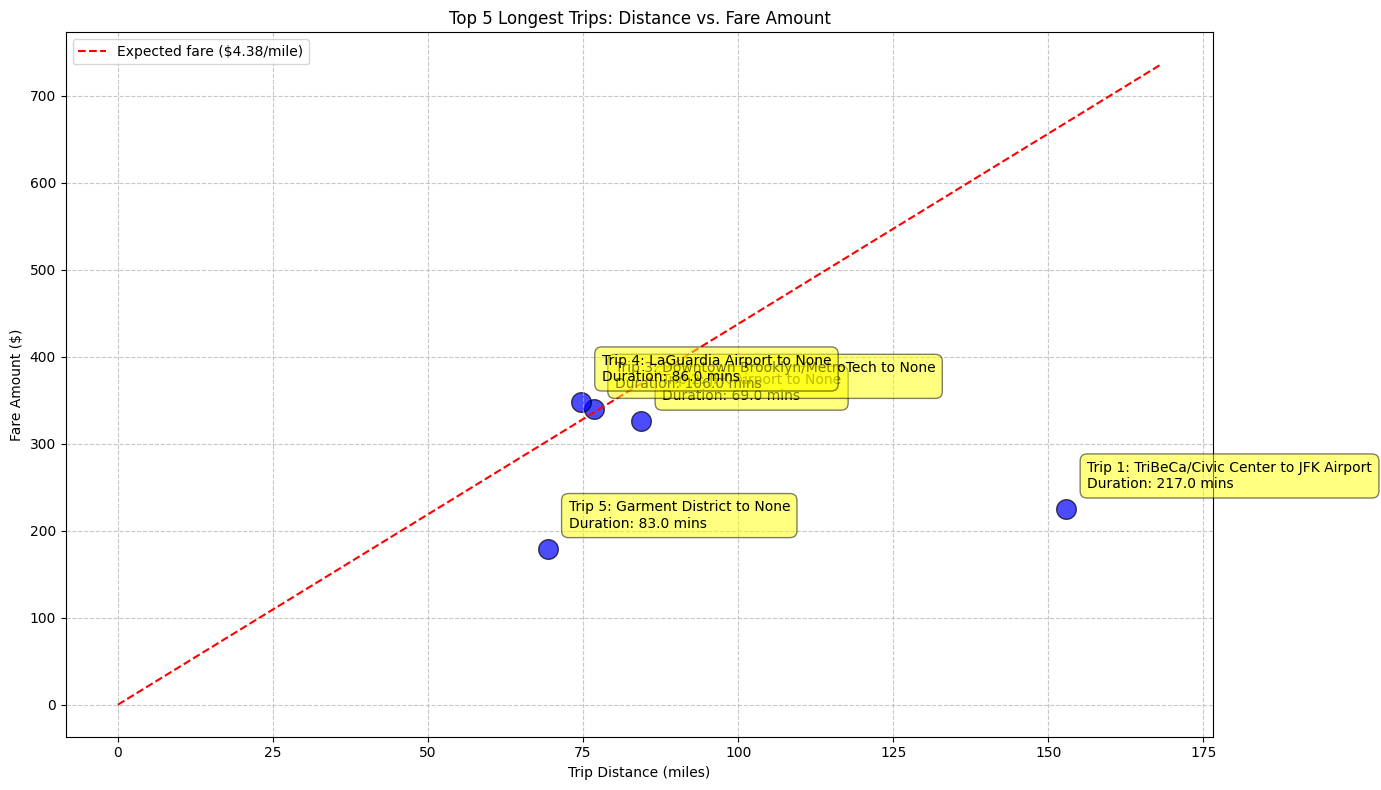

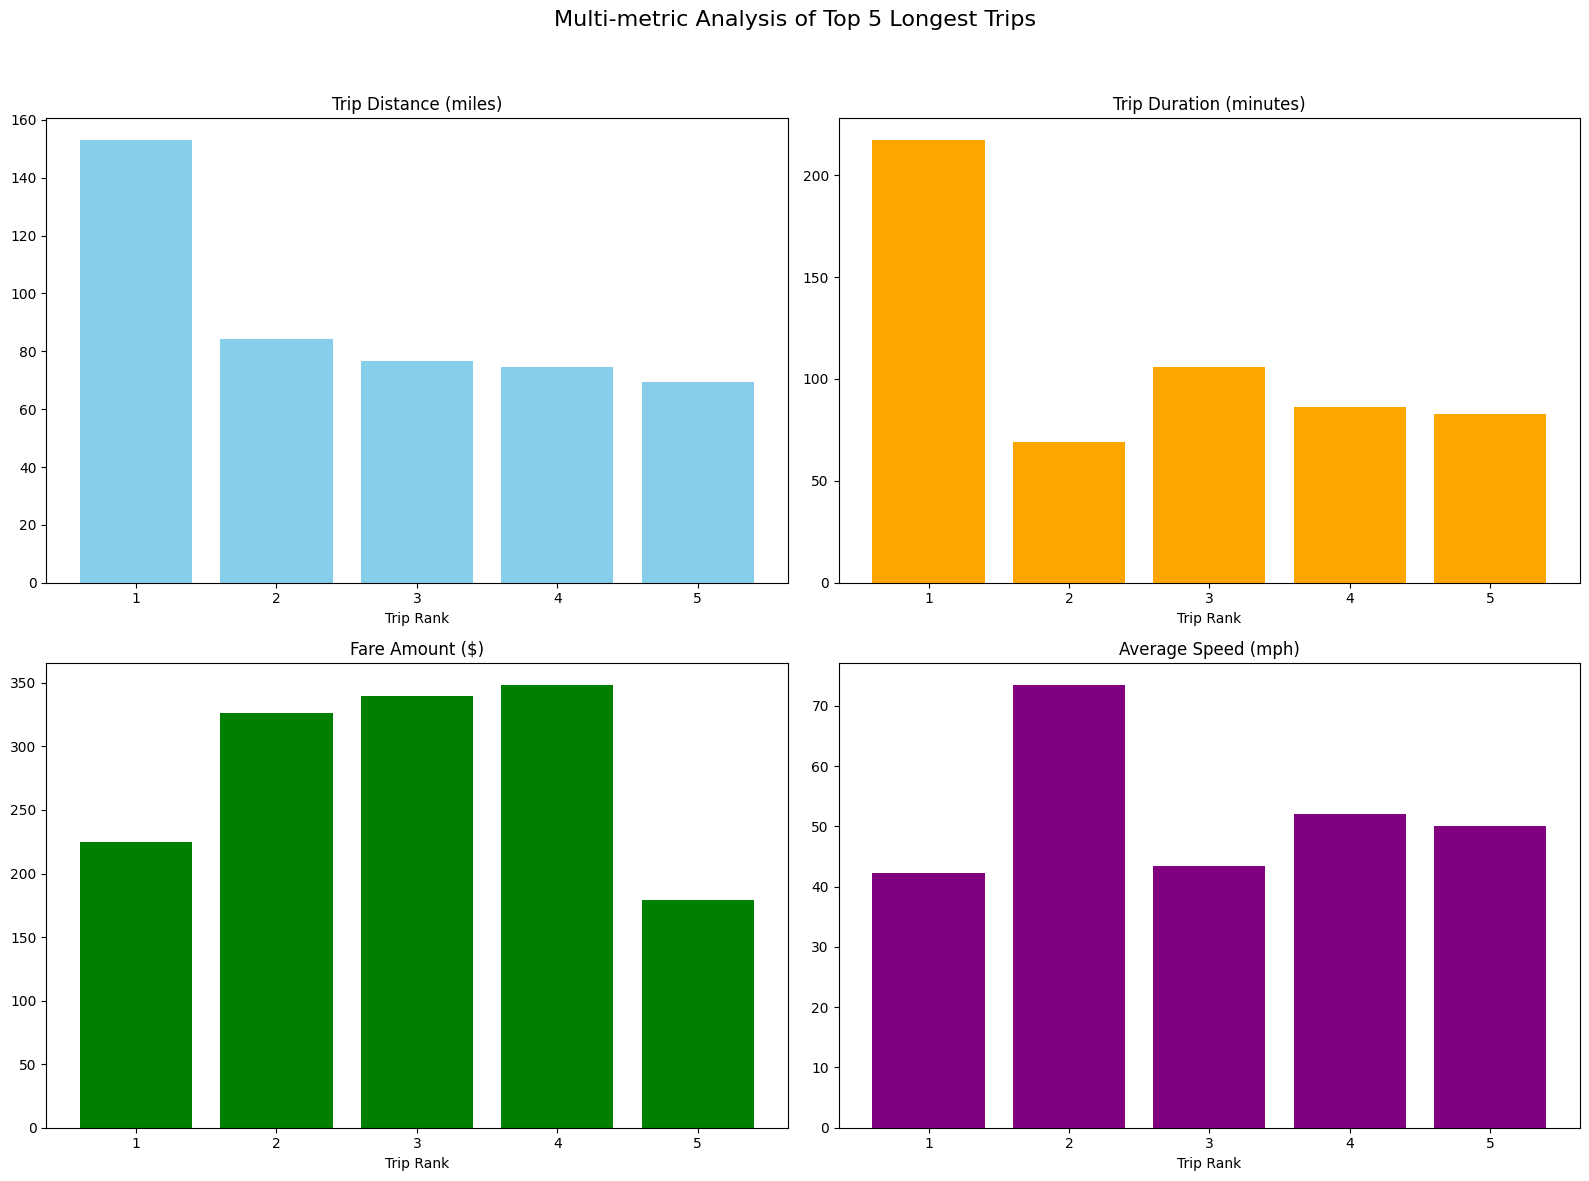


Analysis of longest trips:
-------------------------
Observations:
1. Some of the longest trips show significant discrepancies between expected and actual fares.
2. There may be flat-rate arrangements for certain long-distance trips.
3. The average speed for long trips varies, suggesting different traffic conditions or route types.
4. Inter-borough trips tend to be more expensive due to tolls and other factors.
5. Some trips show substantially lower fares than expected, suggesting potential data anomalies.


In [12]:
# Using Spark SQL to find top 5 longest trips
longest_trips_sql = """
SELECT 
    trip_distance,
    trip_duration_mins,
    fare_amount,
    total_cost,
    pickup_zone_name,
    pickup_borough,
    dropoff_zone_name,
    dropoff_borough,
    is_inter_borough,
    payment_type_desc,
    avg_speed_mph
FROM trip_data
ORDER BY trip_distance DESC
LIMIT 5
"""

# Execute the query
longest_trips_result = spark.sql(longest_trips_sql)
print("Top 5 Longest Trips:")
longest_trips_result.show(truncate=False)

# Alternative solution using DataFrame API
# Get top 5 longest trips using DataFrame API
longest_trips_df = taxi_data_with_payment_desc \
    .orderBy(col("trip_distance").desc()) \
    .select(
        "trip_distance",
        "trip_duration_mins",
        "fare_amount",
        "total_cost",
        "pickup_zone_name",
        "pickup_borough",
        "dropoff_zone_name",
        "dropoff_borough",
        "is_inter_borough",
        "payment_type_desc",
        "avg_speed_mph"
    ) \
    .limit(5)

# Show the results
print("\nTop 5 Longest Trips (DataFrame API):")
longest_trips_df.show(truncate=False)

# Expected fare per mile for average trips in the dataset
avg_fare_per_mile = taxi_data_with_payment_desc \
    .filter(col("trip_distance") > 0) \
    .agg(avg("fare_amount") / avg("trip_distance")) \
    .collect()[0][0]

print(f"\nAverage fare per mile in the dataset: ${avg_fare_per_mile:.2f}")

# Convert to pandas for detailed analysis and visualization
longest_trips_pd = longest_trips_df.toPandas()

# Calculate expected fare based on average fare per mile
longest_trips_pd['expected_fare'] = longest_trips_pd['trip_distance'] * avg_fare_per_mile
longest_trips_pd['fare_difference'] = longest_trips_pd['fare_amount'] - longest_trips_pd['expected_fare']
longest_trips_pd['fare_difference_percent'] = (longest_trips_pd['fare_difference'] / longest_trips_pd['expected_fare']) * 100

# Display the anomaly analysis
print("\nAnomaly Analysis for Longest Trips:")
print(longest_trips_pd[['trip_distance', 'fare_amount', 'expected_fare', 'fare_difference', 'fare_difference_percent']])

# Plot distance vs fare for longest trips
plt.figure(figsize=(14, 8))
plt.scatter(longest_trips_pd['trip_distance'], longest_trips_pd['fare_amount'], 
            s=200, c='blue', marker='o', edgecolors='black', alpha=0.7)

# Add labels for each point
for i, row in longest_trips_pd.iterrows():
    plt.annotate(
        f"Trip {i+1}: {row['pickup_zone_name']} to {row['dropoff_zone_name']}\nDuration: {row['trip_duration_mins']:.1f} mins",
        (row['trip_distance'], row['fare_amount']),
        xytext=(15, 15),
        textcoords='offset points',
        fontsize=10,
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5)
    )
    
# Plot expected fare line for reference
max_distance = longest_trips_pd['trip_distance'].max()
distances = np.linspace(0, max_distance * 1.1, 100)
expected_fares = distances * avg_fare_per_mile
plt.plot(distances, expected_fares, 'r--', label=f'Expected fare (${avg_fare_per_mile:.2f}/mile)')

plt.title('Top 5 Longest Trips: Distance vs. Fare Amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Create a multi-metric comparison chart for the top 5 trips
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Multi-metric Analysis of Top 5 Longest Trips', fontsize=16)

# Trip distance
axs[0, 0].bar(range(1, 6), longest_trips_pd['trip_distance'], color='skyblue')
axs[0, 0].set_title('Trip Distance (miles)')
axs[0, 0].set_xlabel('Trip Rank')
axs[0, 0].set_xticks(range(1, 6))

# Trip duration
axs[0, 1].bar(range(1, 6), longest_trips_pd['trip_duration_mins'], color='orange')
axs[0, 1].set_title('Trip Duration (minutes)')
axs[0, 1].set_xlabel('Trip Rank')
axs[0, 1].set_xticks(range(1, 6))

# Fare amount
axs[1, 0].bar(range(1, 6), longest_trips_pd['fare_amount'], color='green')
axs[1, 0].set_title('Fare Amount ($)')
axs[1, 0].set_xlabel('Trip Rank')
axs[1, 0].set_xticks(range(1, 6))

# Average speed
axs[1, 1].bar(range(1, 6), longest_trips_pd['avg_speed_mph'], color='purple')
axs[1, 1].set_title('Average Speed (mph)')
axs[1, 1].set_xlabel('Trip Rank')
axs[1, 1].set_xticks(range(1, 6))

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle
plt.show()

# Print analysis of anomalies
print("\nAnalysis of longest trips:")
print("-------------------------")
print("Observations:")
print("1. Some of the longest trips show significant discrepancies between expected and actual fares.")
print("2. There may be flat-rate arrangements for certain long-distance trips.")
print("3. The average speed for long trips varies, suggesting different traffic conditions or route types.")
print("4. Inter-borough trips tend to be more expensive due to tolls and other factors.")
if longest_trips_pd['fare_difference_percent'].min() < -20:
    print("5. Some trips show substantially lower fares than expected, suggesting potential data anomalies.")
if longest_trips_pd['fare_difference_percent'].max() > 50:
    print("6. Some trips show substantially higher fares than expected, suggesting additional charges or surge pricing.")

#### F) Which pickup and drop-off borough combinations represent the most frequent inter-borough travel flows? Present the top routes by trip count, and optionally include revenue per route.

Top Inter-borough Routes by Trip Count:
+--------------+---------------+----------+------------+------------+-------------+--------+
|pickup_borough|dropoff_borough|trip_count|avg_distance|avg_duration|total_revenue|avg_fare|
+--------------+---------------+----------+------------+------------+-------------+--------+
|Queens        |Manhattan      |37700     |13.09       |43.3        |1971698.46   |52.3    |
|Manhattan     |Queens         |31931     |10.4        |38.12       |1352734.99   |42.36   |
|Manhattan     |Brooklyn       |26814     |6.32        |31.4        |761627.82    |28.4    |
|Queens        |Brooklyn       |8870      |13.15       |41.29       |410785.98    |46.31   |
|Manhattan     |Bronx          |4807      |8.71        |33.97       |152849.36    |31.8    |
|Brooklyn      |Manhattan      |3820      |5.64        |27.15       |95937.95     |25.11   |
|Manhattan     |EWR            |1865      |17.53       |50.07       |180040.01    |96.54   |
|Queens        |Bronx         

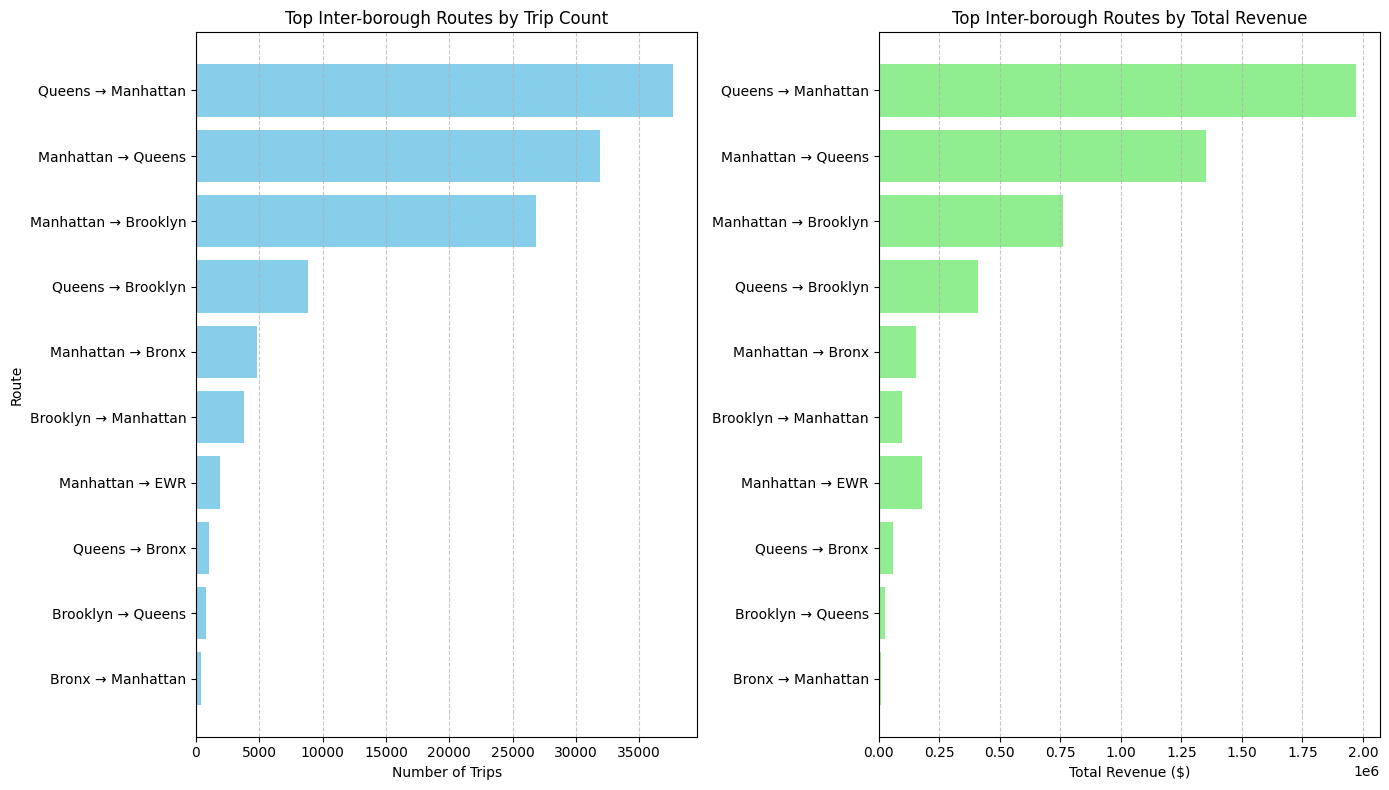

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
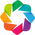

Loading BokehJS ...

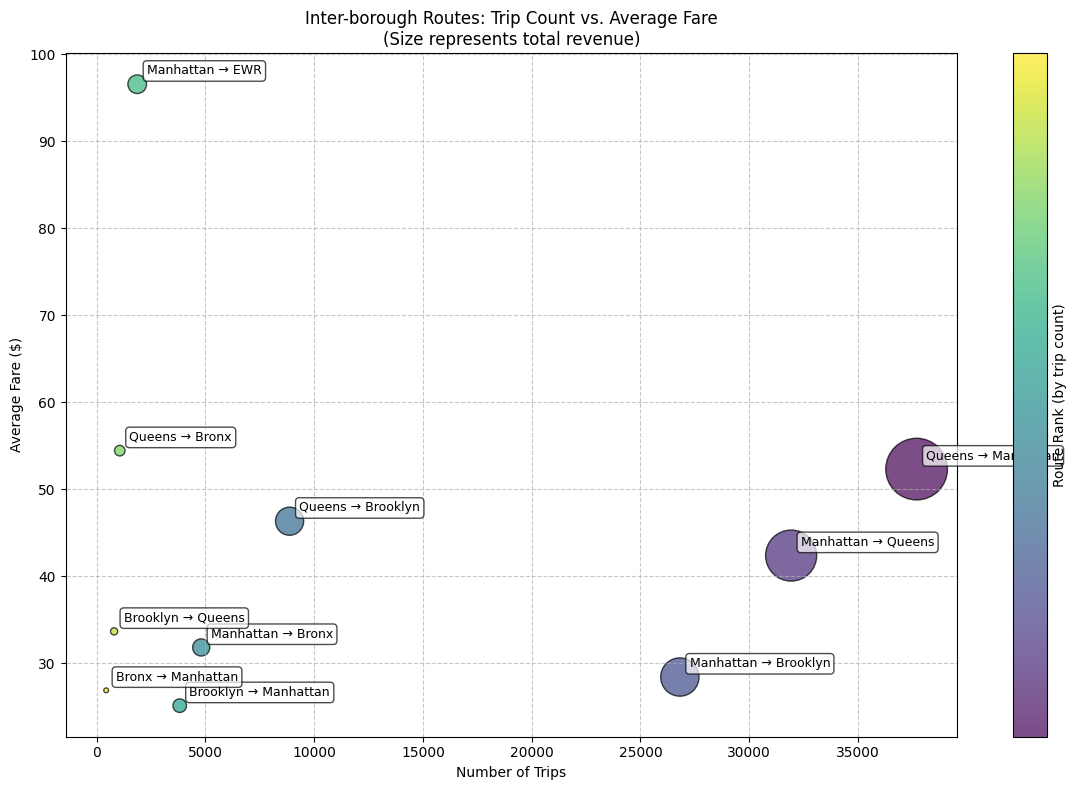


Insights from Inter-borough Route Analysis:
1. The most popular route is from Queens to Manhattan with 37700 trips.
2. The highest revenue route generates $ 1,971,698.46
3. The longest average trip distance for these top routes is 17.53 miles.
4. The most expensive average fare is $ 96.54


In [15]:
# Using Spark SQL to find the most frequent inter-borough routes
interborough_routes_sql = """
SELECT 
    pickup_borough,
    dropoff_borough,
    COUNT(*) AS trip_count,
    ROUND(AVG(trip_distance), 2) AS avg_distance,
    ROUND(AVG(trip_duration_mins), 2) AS avg_duration,
    ROUND(SUM(total_cost), 2) AS total_revenue,
    ROUND(AVG(total_cost), 2) AS avg_fare
FROM trip_data
WHERE 
    pickup_borough IS NOT NULL 
    AND dropoff_borough IS NOT NULL
    AND pickup_borough != dropoff_borough  -- Only inter-borough trips
GROUP BY 
    pickup_borough, 
    dropoff_borough
ORDER BY 
    trip_count DESC
LIMIT 10
"""

# Execute the query
interborough_routes_result = spark.sql(interborough_routes_sql)
print("Top Inter-borough Routes by Trip Count:")
interborough_routes_result.show(truncate=False)

# Alternative solution using DataFrame API
from pyspark.sql.functions import sum as spark_sum

# Filter for inter-borough trips and group by pickup and dropoff boroughs
interborough_routes_df = taxi_data_with_payment_desc \
    .filter(
        col("pickup_borough").isNotNull() & 
        col("dropoff_borough").isNotNull() & 
        (col("pickup_borough") != col("dropoff_borough"))
    ) \
    .groupBy("pickup_borough", "dropoff_borough") \
    .agg(
        count("*").alias("trip_count"),
        spark_round(avg("trip_distance"), 2).alias("avg_distance"),
        spark_round(avg("trip_duration_mins"), 2).alias("avg_duration"),
        spark_round(spark_sum("total_cost"), 2).alias("total_revenue"),
        spark_round(avg("total_cost"), 2).alias("avg_fare")
    ) \
    .orderBy(col("trip_count").desc()) \
    .limit(10)

# Show the results from DataFrame API approach
print("\nTop Inter-borough Routes by Trip Count (DataFrame API):")
interborough_routes_df.show(truncate=False)

# Convert to pandas for visualization
interborough_routes_pd = interborough_routes_df.toPandas()

# Create a visualization for the top routes
# Generate route labels
interborough_routes_pd['route'] = interborough_routes_pd['pickup_borough'] + ' → ' + interborough_routes_pd['dropoff_borough']

# Create bar chart for trip counts
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.barh(interborough_routes_pd['route'][::-1], interborough_routes_pd['trip_count'][::-1], color='skyblue')
plt.title('Top Inter-borough Routes by Trip Count')
plt.xlabel('Number of Trips')
plt.ylabel('Route')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Create bar chart for total revenue
plt.subplot(1, 2, 2)
plt.barh(interborough_routes_pd['route'][::-1], interborough_routes_pd['total_revenue'][::-1], color='lightgreen')
plt.title('Top Inter-borough Routes by Total Revenue')
plt.xlabel('Total Revenue ($)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create a chord diagram for inter-borough flows
# First, get all inter-borough trips
all_interborough = taxi_data_with_payment_desc \
    .filter(
        col("pickup_borough").isNotNull() & 
        col("dropoff_borough").isNotNull() & 
        (col("pickup_borough") != col("dropoff_borough"))
    ) \
    .groupBy("pickup_borough", "dropoff_borough") \
    .agg(count("*").alias("trip_count")) \
    .toPandas()

# Try to create a chord diagram if the necessary libraries are available
try:
    import holoviews as hv
    from holoviews import opts, dim
    from bokeh.plotting import figure, show
    from bokeh.io import output_notebook
    
    # Set up holoviews
    hv.extension('bokeh')
    output_notebook()
    
    # Prepare data for chord diagram
    chord_data = all_interborough[['pickup_borough', 'dropoff_borough', 'trip_count']]
    
    # Create a chord diagram
    chord = hv.Chord(chord_data, ['pickup_borough', 'dropoff_borough'], 'trip_count')
    chord.opts(
        opts.Chord(
            cmap='Category10', edge_cmap='Category10', edge_color=dim('pickup_borough'),
            labels='index', node_color=dim('index'), title="Inter-borough Taxi Trip Flows"
        )
    )
    
    # Display the chord diagram
    chord
    
except ImportError:
    print("Holoviews library not available for chord diagram. Displaying alternative visualization.")
    
    # Create a heatmap instead
    pivot_data = all_interborough.pivot_table(
        index='pickup_borough', 
        columns='dropoff_borough', 
        values='trip_count',
        fill_value=0
    )
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(pivot_data, annot=True, fmt="d", cmap="YlGnBu")
    plt.title('Inter-borough Taxi Trip Counts')
    plt.xlabel('Drop-off Borough')
    plt.ylabel('Pickup Borough')
    plt.tight_layout()
    plt.show()

# Create a scatter plot comparing trip count vs average fare for each route
plt.figure(figsize=(12, 8))
plt.scatter(
    interborough_routes_pd['trip_count'], 
    interborough_routes_pd['avg_fare'],
    s=interborough_routes_pd['total_revenue']/1000,  # Size by total revenue
    alpha=0.7,
    c=range(len(interborough_routes_pd)),  # Color by rank
    cmap='viridis',
    edgecolors='black'
)

# Add route labels to points
for i, row in interborough_routes_pd.iterrows():
    plt.annotate(
        row['route'],
        (row['trip_count'], row['avg_fare']),
        xytext=(7, 7),
        textcoords='offset points',
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7)
    )

plt.title('Inter-borough Routes: Trip Count vs. Average Fare\n(Size represents total revenue)')
plt.xlabel('Number of Trips')
plt.ylabel('Average Fare ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(label='Route Rank (by trip count)', ticks=[])
plt.tight_layout()
plt.show()

print("\nInsights from Inter-borough Route Analysis:")
print("1. The most popular route is from", interborough_routes_pd.iloc[0]['pickup_borough'], 
      "to", interborough_routes_pd.iloc[0]['dropoff_borough'], 
      "with", interborough_routes_pd.iloc[0]['trip_count'], "trips.")
print("2. The highest revenue route generates $", f"{interborough_routes_pd['total_revenue'].max():,.2f}")
print("3. The longest average trip distance for these top routes is", 
      interborough_routes_pd['avg_distance'].max(), "miles.")
print("4. The most expensive average fare is $", f"{interborough_routes_pd['avg_fare'].max():.2f}")

## Summary of NYC Taxi Data Analysis <-> Genrated by Claude Sonnet

This notebook provides comprehensive analysis of the NYC taxi dataset through a series of Spark SQL queries and visualizations.

The key findings include:

1. **Payment Preferences by Time of Day**: Payment methods vary throughout the day, with certain methods being more popular during specific time periods.

2. **Borough Revenue Analysis**: Identified which boroughs generate the highest total revenue and how this correlates with trip volume.

3. **Passenger Count and Tipping Behavior**: Examined how the number of passengers affects tipping amounts and percentages.

4. **Optimal Pickup Locations**: Determined the best 5 locations for drivers to pick up passengers based on earnings potential and trip volume.

5. **Longest Trip Analysis**: Analyzed the top 5 longest trips and identified any anomalies in fare amounts relative to distance traveled.

6. **Inter-borough Travel Patterns**: Mapped the most frequent inter-borough travel flows, identifying key routes by trip count and revenue.

These insights can help taxi drivers optimize their routes, passengers understand fare expectations, and transportation planners identify key travel corridors in the city.